<a href="https://colab.research.google.com/github/zxhom26/SharkPaleobiologyResearch/blob/main/Image_Processing_and_EFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shark Paleobiology Final Project

## Setup environment and pull data from [GitHub](https://github.com/zxhom26/SharkPaleobiologyResearch) repository

In [67]:
%pip install pyefd

In [68]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from functools import reduce
from pyefd import elliptic_fourier_descriptors, normalize_efd, reconstruct_contour
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, round, when
import pandas as pd
from sklearn.decomposition import PCA

In [69]:
from google.colab import userdata
token = userdata.get('shark_paleo_token')

In [70]:
%cd /content
!git config --global user.name "zxhom26"
!git config --global user.email "zxhom26@gmail.com"
!git clone https://github.com/zxhom26/SharkPaleobiologyResearch.git
!git remote set-url origin https://{token}@github.com/zxhom26/SharkPaleobiologyResearch.git
%cd /content/SharkPaleobiologyResearch

/content
fatal: destination path 'SharkPaleobiologyResearch' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
/content/SharkPaleobiologyResearch


## Process Images and Calculate EFDs

In [71]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from pyefd import elliptic_fourier_descriptors, normalize_efd

def process_shark_images(folder, species_label, efd_order=15):
    """
    Load images from a folder, convert to binary, extract largest contour,
    compute normalized EFDs, and return a DataFrame.

    Parameters:
    - folder: str, path to image folder
    - species_label: str, species name to store in DataFrame
    - efd_order: int, number of harmonics for EFD

    Returns:
    - df: Pandas DataFrame with columns: ['image', 'path', 'efa_coeffs', 'species']
    """
    records = []

    for img_path in glob.glob(os.path.join(folder, '*.JPG')):
        # Read grayscale
        gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray is None:
            print(f"Warning: could not read {img_path}")
            continue

        # Threshold to binary (adaptive)
        _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # white tooth, black background!!! REQUIRED FOR CONTOUR

        # Find largest outer contour
        contours, _ = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if not contours:
            print(f"No contours found in {img_path}")
            continue
        contour = max(contours, key=cv2.contourArea) # gets largest contour
        contour = np.squeeze(contour)

        if contour.ndim != 2 or contour.shape[1] != 2 or len(contour) < 5:
            print(f"Invalid contour in {img_path}, shape={contour.shape}")
            continue

        # Compute EFD and normalize
        efd = elliptic_fourier_descriptors(contour, order=efd_order)
        norm_efd = normalize_efd(efd, size_invariant=True)
        # norm_efd = elliptic_fourier_descriptors(contour, order=efd_order)


        # Store record
        records.append({
            'image': bw,
            'path': img_path,
            'efa_coeffs': norm_efd,
            'species': species_label
        })

    df = pd.DataFrame(records)
    return df, contour, efd


###Run Elliptical Fourier Analysis

In [72]:
df_bull, bull_contour, last_bull_efd = process_shark_images('/content/SharkPaleobiologyResearch/Bull/','Bull')
df_java, java_contour, last_java_efd = process_shark_images('/content/SharkPaleobiologyResearch/Java/','Java')


###Contour Reconstruction to Validate EFD

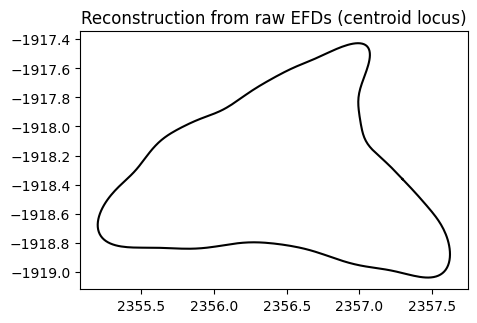

In [73]:
# Reconstruct contour test
A0 = bull_contour[:,0].mean()   # mean x
C0 = bull_contour[:,1].mean()   # mean y
recon = reconstruct_contour(last_bull_efd, locus=(A0, C0), num_points=400)
x, y = recon[:,0], recon[:,1]
plt.figure(figsize=(5,6))
plt.plot(x, -y, '-k')                          # invert y to match cv2 visual coords
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstruction from raw EFDs (centroid locus)')
plt.show()

##Principal Component Analysis (PCA)
- Linear dimension reduction technique

In [74]:
# from sklearn.datasets import load_iris
# iris = load_iris()
# iris.data
# X_reduced = PCA(n_components=3).fit_transform(iris.data)

###Run PCA

In [75]:
def pca_decomposition(df, n_components=1):
    # Flatten each EFD coefficient matrix into a row vector
    X = np.array([c.flatten() for c in df['efa_coeffs']])

    pca = PCA(n_components=n_components)
    pca_scores = pca.fit_transform(X)

    df['pca'] = pca_scores[:, 0]

    return df

In [76]:
pca_bull = pca_decomposition(df_bull)
pca_java = pca_decomposition(df_java)
pca_teeth = pd.concat([df_bull, df_java])

###Plot PCA Groupings

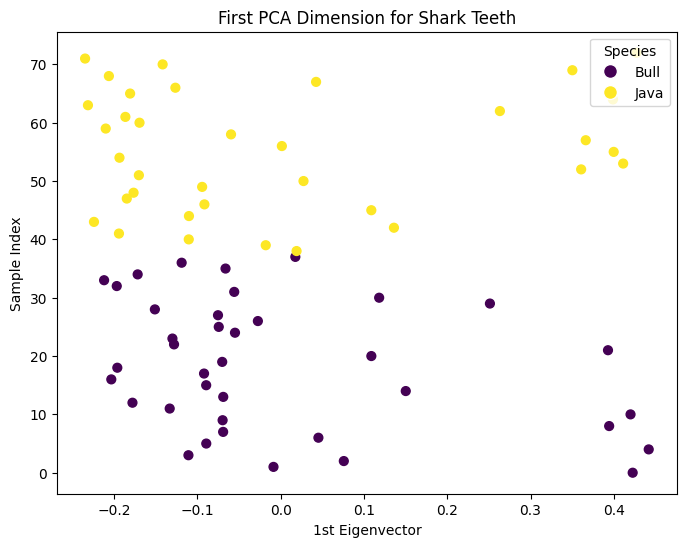

In [77]:
fig = plt.figure(1, figsize=(8, 6))
# Changed to 2D subplot as X_reduced is 1D
ax = fig.add_subplot(111)

X_reduced = pca_teeth['pca'] # This is a pandas Series

# Encode species for coloring
unique_species = pca_teeth['species'].unique()
species_colors = {species: i for i, species in enumerate(unique_species)}
c_values = pca_teeth['species'].map(species_colors)

# Get a colormap for the legend
num_species = len(unique_species)
# Updated to use the recommended way to get a colormap
colormap = plt.get_cmap('viridis', num_species)

scatter = ax.scatter(
    X_reduced, # Correctly use the 1D Series
    np.arange(len(X_reduced)), # Use sample index for the Y-axis to visualize individual points
    c=c_values, # Use encoded species for coloring
    cmap=colormap, # Specify the colormap
    s=40,
)

ax.set(
    title="First PCA Dimension for Shark Teeth",
    xlabel="1st Eigenvector",
    ylabel="Sample Index",
)
# Removed set_ticklabels for x and y as they are now meaningful
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])
# ax.zaxis.set_ticklabels([]) # Removed for 2D plot

# Add a legend based on species
legend_handles = []
for species, color_val in species_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=species,
                                 markerfacecolor=colormap(color_val / (num_species - 1) if num_species > 1 else 0.5),
                                 markersize=10))

ax.legend(handles=legend_handles, loc="upper right", title="Species")

plt.show()

##T-Distributed Stochastic Neighbor Embedding (t-SNE)
- Non-linear dimension reduction technique

###Run t-SNE

In [90]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_decomposition(df, n_components=1):
    # Flatten each EFD coefficient matrix into a row vector
    X = np.array([c.flatten() for c in df['efa_coeffs']])

    tsne = TSNE(n_components=n_components, perplexity=20, init='random', random_state=42)
    tsne_scores = tsne.fit_transform(X)

    df['tsne'] = tsne_scores[:, 0]

    return df

In [91]:
tsne_bull = tsne_decomposition(pca_bull)
tsne_java = tsne_decomposition(pca_java)
tsne_teeth = pd.concat([tsne_bull, tsne_java])

###Plot t-SNE Groupings

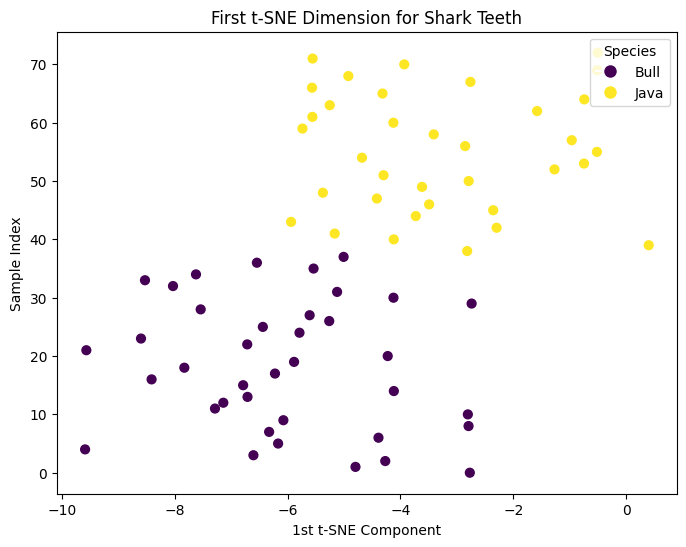

In [92]:
X_embedded = tsne_teeth['tsne']

# Visualize the results for 1D t-SNE, similar to PCA plot
fig, ax = plt.subplots(figsize=(8, 6))

# Encode species for coloring
unique_species = tsne_teeth['species'].unique()
species_colors = {species: i for i, species in enumerate(unique_species)}
c_values = tsne_teeth['species'].map(species_colors)

# Get a colormap for the legend
num_species = len(unique_species)
colormap = plt.get_cmap('viridis', num_species)

scatter = ax.scatter(
    X_embedded, # Use the 1D t-SNE scores directly for the x-axis
    np.arange(len(X_embedded)), # Use sample index for the Y-axis
    c=c_values, # Use encoded species for coloring
    cmap=colormap, # Specify the colormap
    s=40,
)

ax.set(
    title="First t-SNE Dimension for Shark Teeth",
    xlabel="1st t-SNE Component",
    ylabel="Sample Index",
)

# Add a legend based on species
legend_handles = []
for species, color_val in species_colors.items():
    # Adjusted markerfacecolor calculation for colormap
    color_normalized = color_val / (num_species - 1) if num_species > 1 else 0.5
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=species,
                                 markerfacecolor=colormap(color_normalized),
                                 markersize=10))

ax.legend(handles=legend_handles, loc="upper right", title="Species")

plt.show()